In [114]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 8
num_classes = 2 # normal: 0, crash: 1
learning_rate = 1e-3
num_epochs = 30

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Dataset

In [115]:
import os
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

# 定义数据转换
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # fixed image dimension
    transforms.ToTensor(),           # make np to tensor
])

# dataset
class MEL_Dataset(Dataset):
    def __init__(self, mel_folder, transform=None):
        self.melfolder = mel_folder
        self.mel_file = os.listdir(mel_folder)
        self.transform = transform
    def __len__(self):
        return len(self.mel_file)
    def __getitem__(self, idx):
        mel_file = self.mel_file[idx]
        # 範例：載入 precomputed mel tensor (n_mel, SPEC_WIDTH)
        filepath = os.path.join(self.melfolder, mel_file)
        mel = Image.open(filepath).convert('RGB')
        # make into binary classificaton
        label = 0 if int(mel_file.split('_')[0]) < 5 else 1  # 假設標籤是文件名稱的一部分
        if self.transform:
            mel = self.transform(mel)
        return mel, label


# 獲取相關信息
source_folder = '../dataset/mel_spectrograms'
dataset = MEL_Dataset(source_folder, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# DataLoader for batching
for i, (mel, label) in enumerate(dataloader):
    # 在這裡進行訓練或驗證
    print(f"Batch {i}: MEL shape: {mel.shape}, Label: {label}")
    break

Batch 0: MEL shape: torch.Size([8, 3, 224, 224]), Label: tensor([1, 0, 0, 1, 0, 0, 1, 0])


Group-K fold

In [116]:
import numpy as np
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset, DataLoader

def create_group_kfold_loaders(dataset, batch_size, n_splits=5):
    """
    Split dataset using GroupKFold based on video names.
    Returns list of (train_loader, test_loader) tuples for each fold.
    """
    # Extract filenames to create groups
    mel_files = dataset.mel_file
    filenames = []
    groups = []
    labels = []

    for file in mel_files:
        # Extract video name (assuming format: label_videoname_segment.npy)
        filename = file.split('_')[1]  # Get the video name part
        filenames.append(filename)
        labels.append(0 if int(file.split('_')[0]) < 5 else 1)
    
    # Convert filenames to group indices
    unique_filenames = list(set(filenames))
    groups = [unique_filenames.index(fname) for fname in filenames]
    
    # Create indices for GroupKFold
    indices = np.arange(len(dataset))
    
    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)
    
    # Create loaders for each fold
    fold_loaders = []
    for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(indices, labels, groups)):
        # Create subsets for train and test
        # select specific range of data
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
        
        fold_loaders.append((train_loader, test_loader, fold_idx))
    
    return fold_loaders

# Example usage
if __name__ == '__main__':
    fold_loaders = create_group_kfold_loaders(dataset, batch_size)
    
    # Now you can iterate through folds
    for train_loader, test_loader, fold_idx in fold_loaders:
        print(f"Fold {fold_idx}:")
        print(f"  Training samples: {len(train_loader.dataset)}")
        print(f"  Testing samples: {len(test_loader.dataset)}")

Fold 0:
  Training samples: 328
  Testing samples: 82
Fold 1:
  Training samples: 328
  Testing samples: 82
Fold 2:
  Training samples: 328
  Testing samples: 82
Fold 3:
  Training samples: 328
  Testing samples: 82
Fold 4:
  Training samples: 328
  Testing samples: 82


`Anomaly Detection` with Autoencoder

In [117]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(3,369,496)
        self.layer1 = self.input_processing_block(3, 16) #output_shape=(16,184,248)

        # 依序定義 channel 變化
        self.channel_list = [16, 64, 32, 16, 8]

        self.res_blocks = nn.ModuleList()
        for i in range(len(self.channel_list)-1):
            in_c = self.channel_list[i]
            out_c = self.channel_list[i+1]
            self.res_blocks.append(nn.ModuleDict({
                'conv': self.conv_block(in_c, out_c),
                'res': self.residue_block(in_c, out_c)
            }))

        # 用 dummy 計算 flatten_size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            out = self.layer1(dummy)
            for block in self.res_blocks:
                conv_out = block['conv'](out)
                res_out = block['res'](out)
                out = conv_out + res_out
                out = F.relu(out)
                out = nn.MaxPool2d(kernel_size=2)(out)
            self.flatten_size = out.view(1, -1).shape[1]
        # output_shape = (8, 23, 31)

        # final layers
        self.layer3 = self.classification_block(self.flatten_size, 512) #output_shape=(2,)

    def forward(self, x):
        # Convolutions
        out = self.layer1(x)

        # Apply residual connections
        for block in self.res_blocks:
            conv_out = block['conv'](out)
            res_out = block['res'](out)
            out = conv_out + res_out
            out = F.relu(out)
            out = nn.MaxPool2d(kernel_size=2)(out)

        out = self.layer3(out)

        return out
    
    def input_processing_block(self, in_channels, out_channels):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    def conv_block(self, in_channels, out_channels):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),    # expand the channels
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def residue_block(self, in_channels, out_channels):
        "By giving the parameters, the function will return a residual module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),    # expand the channels
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def classification_block(self, in_channels, out_channels):
        "By giving the parameters, the function will return a classification module"
        return nn.Sequential(
            nn.Dropout(0.3),  # dropout layer
            nn.Flatten(),  # flatten the output
            nn.Linear(in_channels, out_channels),  # fully connected layer
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(0.3),
            nn.Linear(out_channels, num_classes)  # final output layer
        )

In [118]:
import torchinfo

model = CNN_Model()
test_input = torch.randn(1, 3, 224, 224)  # Example input tensor
print(f"Model's structure:\n {torchinfo.summary(model, input_size=test_input.shape)}")

Model's structure:
Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model                                [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 16, 224, 224]         1,216
│    └─ReLU: 2-2                         [1, 16, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 16, 224, 224]         32
│    └─MaxPool2d: 2-4                    [1, 16, 112, 112]         --
├─ModuleList: 1-2                        --                        --
│    └─ModuleDict: 2-5                   --                        --
│    │    └─Sequential: 3-1              [1, 64, 112, 112]         38,272
│    │    └─Sequential: 3-2              [1, 64, 112, 112]         1,216
│    └─ModuleDict: 2-6                   --                        --
│    │    └─Sequential: 3-3              [1, 32, 56, 56]           11,456
│    │    └─Sequential: 3-4              [1, 32, 56,

In [119]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = CNN_Model()
        self.decoder = nn.Sequential(
            nn.Linear(2, 512),
            nn.ReLU(),
            nn.Linear(512, 392),
            nn.ReLU(),
            nn.Unflatten(1, (8, 7, 7)),
            # deconvolution
            nn.ConvTranspose2d(8, 32, 3, stride=2, padding=1, output_padding=1),  # [8,7,7] -> [32,14,14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [32,14,14] -> [16,28,28]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),   # [16,28,28] -> [8,56,56]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),    # [8,56,56] -> [3,112,112]
            nn.ConvTranspose2d(3, 3, 3, stride=2, padding=1, output_padding=1),    # [3,112,112] -> [3,224,224]
            nn.Sigmoid(),  # 輸出範圍為 [0, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [120]:
import torchinfo

model = Autoencoder()
test_input = torch.randn(1, 3, 224, 224)  # Example input tensor
print(f"Model's structure:\n {torchinfo.summary(model, input_size=test_input.shape)}")

Model's structure:
Layer (type:depth-idx)                        Output Shape              Param #
Autoencoder                                   [1, 3, 224, 224]          --
├─CNN_Model: 1-1                              [1, 2]                    --
│    └─Sequential: 2-1                        [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 16, 224, 224]         1,216
│    │    └─ReLU: 3-2                         [1, 16, 224, 224]         --
│    │    └─BatchNorm2d: 3-3                  [1, 16, 224, 224]         32
│    │    └─MaxPool2d: 3-4                    [1, 16, 112, 112]         --
│    └─ModuleList: 2-2                        --                        --
│    │    └─ModuleDict: 3-5                   --                        39,488
│    │    └─ModuleDict: 3-6                   --                        13,600
│    │    └─ModuleDict: 3-7                   --                        3,472
│    │    └─ModuleDict: 3-8                   --              

Train and Evaluation

In [121]:
def train_autoencoder(autoencoder, train_loader, epochs=10, lr=1e-3):
    autoencoder.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")

In [122]:
def threshold_generation(autoencoder, train_loader):
    """
        Generate thresholds for anomaly detection based on reconstruction errors from training data.
    """
    autoencoder.eval()
    recon_errors = []
    true_labels = []

    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = torch.mean((outputs - images) ** 2, dim=(1, 2, 3))  # 每張圖片的 MSE
            recon_errors.extend(loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    recon_errors = np.array(recon_errors)
    true_labels = np.array(true_labels)

    return recon_errors, true_labels

In [123]:
from sklearn.metrics import classification_report, roc_auc_score
def evaluate_autoencoder(autoencoder, test_loader, threshold=None):
    autoencoder.eval()
    recon_errors = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = torch.mean((outputs - images) ** 2, dim=(1, 2, 3))  # 每張圖片的 MSE
            recon_errors.extend(loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    recon_errors = np.array(recon_errors)
    true_labels = np.array(true_labels)

    # 閾值設定：預設用百分位（如95% MNIST誤差）
    if threshold is None:
        normal_errors = recon_errors[true_labels == 0]
        if len(normal_errors) == 0:
            print("⚠️ 測試集沒有正常樣本，無法自動計算 threshold！")
            threshold = np.percentile(recon_errors, 95)  # fallback：直接用所有樣本
        else:
            threshold = np.percentile(normal_errors, 95)  # 第95位數
            print(f"自動設定閾值為：{threshold:.6f}")

    preds = (recon_errors > threshold).astype(int)  # 高於閾值視為異常

    print(f"\n=== Autoencoder Reconstruction Error-based Anomaly Detection ===")
    print(classification_report(true_labels, preds, digits=4))
    print("AUC:", roc_auc_score(true_labels, recon_errors))

    return recon_errors, preds, true_labels, threshold

In [124]:
def plot_recon_error_distribution(recon_errors, true_labels, threshold):
    import matplotlib.pyplot as plt

    plt.hist(recon_errors[true_labels == 0], bins=50, alpha=0.6, label="Driving (normal)")
    plt.hist(recon_errors[true_labels == 1], bins=50, alpha=0.6, label="Car crash (anomaly)")
    plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.4f}")
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Number of Samples")
    plt.legend()
    plt.title("Reconstruction Error Distribution")
    plt.show()


Fold 0:
  Training samples: 328
  Testing samples: 82
Epoch 1/50, Loss: 0.053679
Epoch 2/50, Loss: 0.036093
Epoch 3/50, Loss: 0.025832
Epoch 4/50, Loss: 0.024615
Epoch 5/50, Loss: 0.024301
Epoch 6/50, Loss: 0.024084
Epoch 7/50, Loss: 0.023948
Epoch 8/50, Loss: 0.023836
Epoch 9/50, Loss: 0.023662
Epoch 10/50, Loss: 0.023546
Epoch 11/50, Loss: 0.023380
Epoch 12/50, Loss: 0.023189
Epoch 13/50, Loss: 0.022545
Epoch 14/50, Loss: 0.020374
Epoch 15/50, Loss: 0.015640
Epoch 16/50, Loss: 0.013416
Epoch 17/50, Loss: 0.012380
Epoch 18/50, Loss: 0.012171
Epoch 19/50, Loss: 0.011034
Epoch 20/50, Loss: 0.011012
Epoch 21/50, Loss: 0.011068
Epoch 22/50, Loss: 0.010408
Epoch 23/50, Loss: 0.010049
Epoch 24/50, Loss: 0.010244
Epoch 25/50, Loss: 0.009899
Epoch 26/50, Loss: 0.010435
Epoch 27/50, Loss: 0.010394
Epoch 28/50, Loss: 0.010427
Epoch 29/50, Loss: 0.010337
Epoch 30/50, Loss: 0.010161
Epoch 31/50, Loss: 0.010408
Epoch 32/50, Loss: 0.009544
Epoch 33/50, Loss: 0.010401
Epoch 34/50, Loss: 0.009759
Epo

d:\ancode\envs\torch\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\ancode\envs\torch\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\ancode\envs\torch\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\ancode\envs\torch\Lib\site-packages\sklearn\metrics\_ranking.

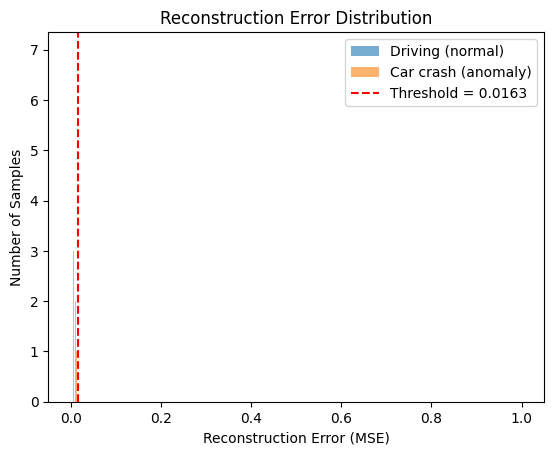

Fold 1:
  Training samples: 328
  Testing samples: 82
Epoch 1/50, Loss: 0.009392
Epoch 2/50, Loss: 0.009371
Epoch 3/50, Loss: 0.009313
Epoch 4/50, Loss: 0.009194
Epoch 5/50, Loss: 0.008866
Epoch 6/50, Loss: 0.008875
Epoch 7/50, Loss: 0.009148
Epoch 8/50, Loss: 0.008809
Epoch 9/50, Loss: 0.008941
Epoch 10/50, Loss: 0.008983
Epoch 11/50, Loss: 0.009191
Epoch 12/50, Loss: 0.008870
Epoch 13/50, Loss: 0.009075
Epoch 14/50, Loss: 0.009403
Epoch 15/50, Loss: 0.009014
Epoch 16/50, Loss: 0.008832
Epoch 17/50, Loss: 0.008750
Epoch 18/50, Loss: 0.009116
Epoch 19/50, Loss: 0.008845
Epoch 20/50, Loss: 0.008588
Epoch 21/50, Loss: 0.008664
Epoch 22/50, Loss: 0.008781
Epoch 23/50, Loss: 0.008952
Epoch 24/50, Loss: 0.008797
Epoch 25/50, Loss: 0.008512
Epoch 26/50, Loss: 0.008793
Epoch 27/50, Loss: 0.009144
Epoch 28/50, Loss: 0.008888
Epoch 29/50, Loss: 0.008756
Epoch 30/50, Loss: 0.008999
Epoch 31/50, Loss: 0.008766
Epoch 32/50, Loss: 0.008836
Epoch 33/50, Loss: 0.008871
Epoch 34/50, Loss: 0.008767
Epo

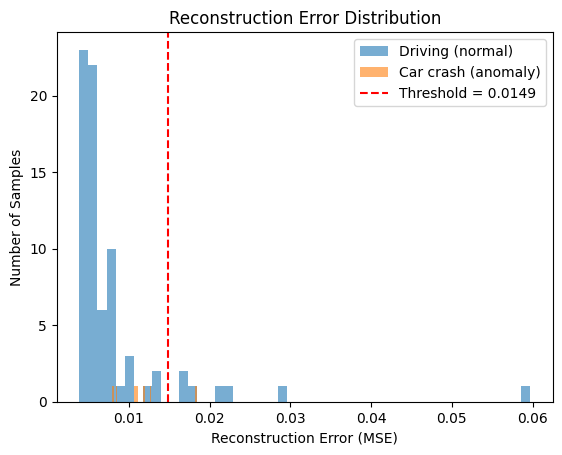

Fold 2:
  Training samples: 328
  Testing samples: 82
Epoch 1/50, Loss: 0.009043
Epoch 2/50, Loss: 0.008727
Epoch 3/50, Loss: 0.008515
Epoch 4/50, Loss: 0.008809
Epoch 5/50, Loss: 0.008704
Epoch 6/50, Loss: 0.008452
Epoch 7/50, Loss: 0.008585
Epoch 8/50, Loss: 0.008751
Epoch 9/50, Loss: 0.008638
Epoch 10/50, Loss: 0.008559
Epoch 11/50, Loss: 0.008483
Epoch 12/50, Loss: 0.008738
Epoch 13/50, Loss: 0.008486
Epoch 14/50, Loss: 0.008777
Epoch 15/50, Loss: 0.008436
Epoch 16/50, Loss: 0.008166
Epoch 17/50, Loss: 0.008298
Epoch 18/50, Loss: 0.008665
Epoch 19/50, Loss: 0.008622
Epoch 20/50, Loss: 0.008590
Epoch 21/50, Loss: 0.008479
Epoch 22/50, Loss: 0.008633
Epoch 23/50, Loss: 0.008725
Epoch 24/50, Loss: 0.008447
Epoch 25/50, Loss: 0.008328
Epoch 26/50, Loss: 0.008250
Epoch 27/50, Loss: 0.008369
Epoch 28/50, Loss: 0.009013
Epoch 29/50, Loss: 0.008659
Epoch 30/50, Loss: 0.008496
Epoch 31/50, Loss: 0.008331
Epoch 32/50, Loss: 0.008430
Epoch 33/50, Loss: 0.008535
Epoch 34/50, Loss: 0.008403
Epo

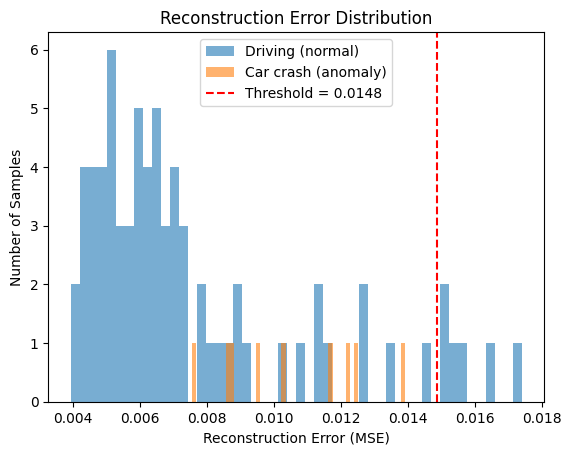

Fold 3:
  Training samples: 328
  Testing samples: 82
Epoch 1/50, Loss: 0.008731
Epoch 2/50, Loss: 0.008490
Epoch 3/50, Loss: 0.008460
Epoch 4/50, Loss: 0.008443
Epoch 5/50, Loss: 0.008181
Epoch 6/50, Loss: 0.008097
Epoch 7/50, Loss: 0.008550
Epoch 8/50, Loss: 0.008778
Epoch 9/50, Loss: 0.008289
Epoch 10/50, Loss: 0.008130
Epoch 11/50, Loss: 0.008670
Epoch 12/50, Loss: 0.008405
Epoch 13/50, Loss: 0.008206
Epoch 14/50, Loss: 0.008399
Epoch 15/50, Loss: 0.008206
Epoch 16/50, Loss: 0.008419
Epoch 17/50, Loss: 0.008218
Epoch 18/50, Loss: 0.008094
Epoch 19/50, Loss: 0.008529
Epoch 20/50, Loss: 0.008246
Epoch 21/50, Loss: 0.008290
Epoch 22/50, Loss: 0.008266
Epoch 23/50, Loss: 0.007919
Epoch 24/50, Loss: 0.008045
Epoch 25/50, Loss: 0.008138
Epoch 26/50, Loss: 0.008122
Epoch 27/50, Loss: 0.008565
Epoch 28/50, Loss: 0.008309
Epoch 29/50, Loss: 0.008190
Epoch 30/50, Loss: 0.008125
Epoch 31/50, Loss: 0.008006
Epoch 32/50, Loss: 0.008225
Epoch 33/50, Loss: 0.008070
Epoch 34/50, Loss: 0.008339
Epo

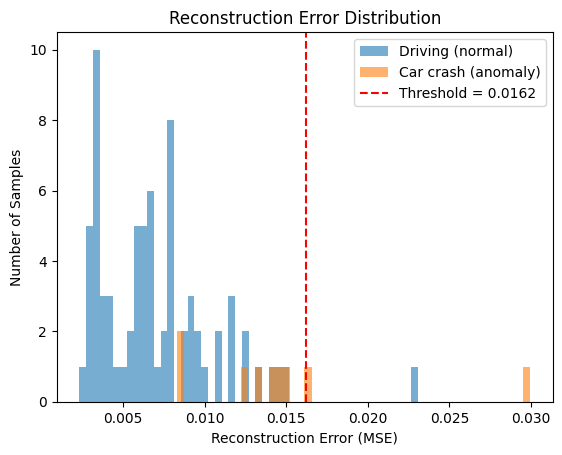

Fold 4:
  Training samples: 328
  Testing samples: 82
Epoch 1/50, Loss: 0.008026
Epoch 2/50, Loss: 0.007955
Epoch 3/50, Loss: 0.007680
Epoch 4/50, Loss: 0.007869
Epoch 5/50, Loss: 0.007602
Epoch 6/50, Loss: 0.007974
Epoch 7/50, Loss: 0.007989
Epoch 8/50, Loss: 0.007931
Epoch 9/50, Loss: 0.007808
Epoch 10/50, Loss: 0.007726
Epoch 11/50, Loss: 0.007691
Epoch 12/50, Loss: 0.007894
Epoch 13/50, Loss: 0.008124
Epoch 14/50, Loss: 0.007848
Epoch 15/50, Loss: 0.007806
Epoch 16/50, Loss: 0.007753
Epoch 17/50, Loss: 0.007852
Epoch 18/50, Loss: 0.007754
Epoch 19/50, Loss: 0.007711
Epoch 20/50, Loss: 0.007807
Epoch 21/50, Loss: 0.007791
Epoch 22/50, Loss: 0.007701
Epoch 23/50, Loss: 0.007631
Epoch 24/50, Loss: 0.007765
Epoch 25/50, Loss: 0.007936
Epoch 26/50, Loss: 0.007659
Epoch 27/50, Loss: 0.007994
Epoch 28/50, Loss: 0.007719
Epoch 29/50, Loss: 0.007675
Epoch 30/50, Loss: 0.007941
Epoch 31/50, Loss: 0.007819
Epoch 32/50, Loss: 0.007818
Epoch 33/50, Loss: 0.008082
Epoch 34/50, Loss: 0.007507
Epo

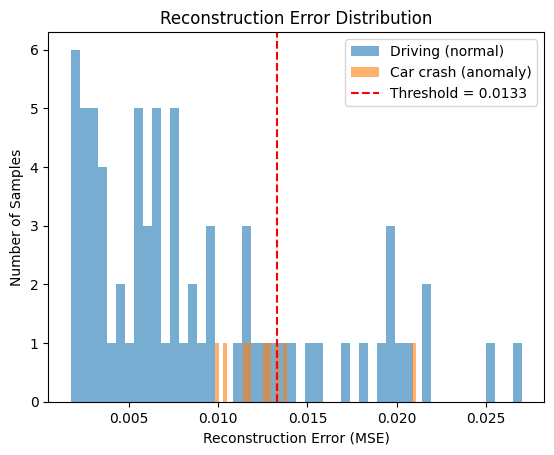

In [128]:
# 建立與訓練 autoencoder
autoencoder = Autoencoder().to(device)

fold_loaders = create_group_kfold_loaders(dataset, batch_size)
    
# Now you can iterate through folds
for train_loader, test_loader, fold_idx in fold_loaders:
    print(f"Fold {fold_idx}:")
    print(f"  Training samples: {len(train_loader.dataset)}")
    print(f"  Testing samples: {len(test_loader.dataset)}")
    # 訓練 AutoEncoder
    train_autoencoder(autoencoder, train_loader, epochs=50)
    
    # threshold
    recon_errors, true_labels = threshold_generation(autoencoder, train_loader)
    normal_errors = recon_errors[true_labels == 0]
    threshold = np.percentile(normal_errors, 95)

    # 測試 autoencoder 並回傳結果
    recon_errors, preds, true_labels, threshold = evaluate_autoencoder(autoencoder, test_loader, threshold=threshold)

    # 畫圖顯示誤差分布
    plot_recon_error_distribution(recon_errors, true_labels, threshold)
